In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from hcmus.core import appconfig

2025-06-12 21:49:26.935 | INFO     | hcmus.core.appconfig:<module>:7 - Load DotEnv: True


In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import timm
from loguru import logger
from torch.utils.data import DataLoader
from tqdm import tqdm
from hcmus.data import CroppedObjectClassificationDataset

/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
transform_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [8]:
import mlflow
import json
from ultralytics import YOLO
run_id = "c06c44932cc14d9c835bdcfd6075ac2e"
weights = mlflow.artifacts.download_artifacts(f"runs:/{run_id}/weights/best.pt")
yolo_model = YOLO(weights)

In [9]:
run_id = "3e39d883b4464f9c802e0a0db508c982"
classifer = mlflow.pytorch.load_model(f"runs:/{run_id}/model")
label2idx = mlflow.artifacts.download_artifacts(f"runs:/{run_id}/label2idx.json")
label2idx = json.load(open(label2idx))
classifer.eval()

Sequential(
  (0): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): DenseBlock(
        (denselayer1): DenseLayer(
          (norm1): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNormAct2d(
            128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv2): Conv2d(128, 32, kernel_siz

In [30]:
def predict_image_class(model, image, transform):
    input_tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_tensor)
        if outputs.ndim > 1 and outputs.shape[1] > 1:
            predicted_class = torch.argmax(outputs, dim=1).item()
            return predicted_class, outputs.max().item()
        else:
            raise ValueError("Model output is not classification logits")

In [ ]:
from PIL import Image, ImageOps
from hcmus.utils import viz_utils


0: 480x640 24 objects, 48.9ms
Speed: 1.7ms preprocess, 48.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


In [13]:
idx2label = {v: k for k, v in label2idx.items()}


0: 480x640 26 objects, 41.1ms
Speed: 1.3ms preprocess, 41.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


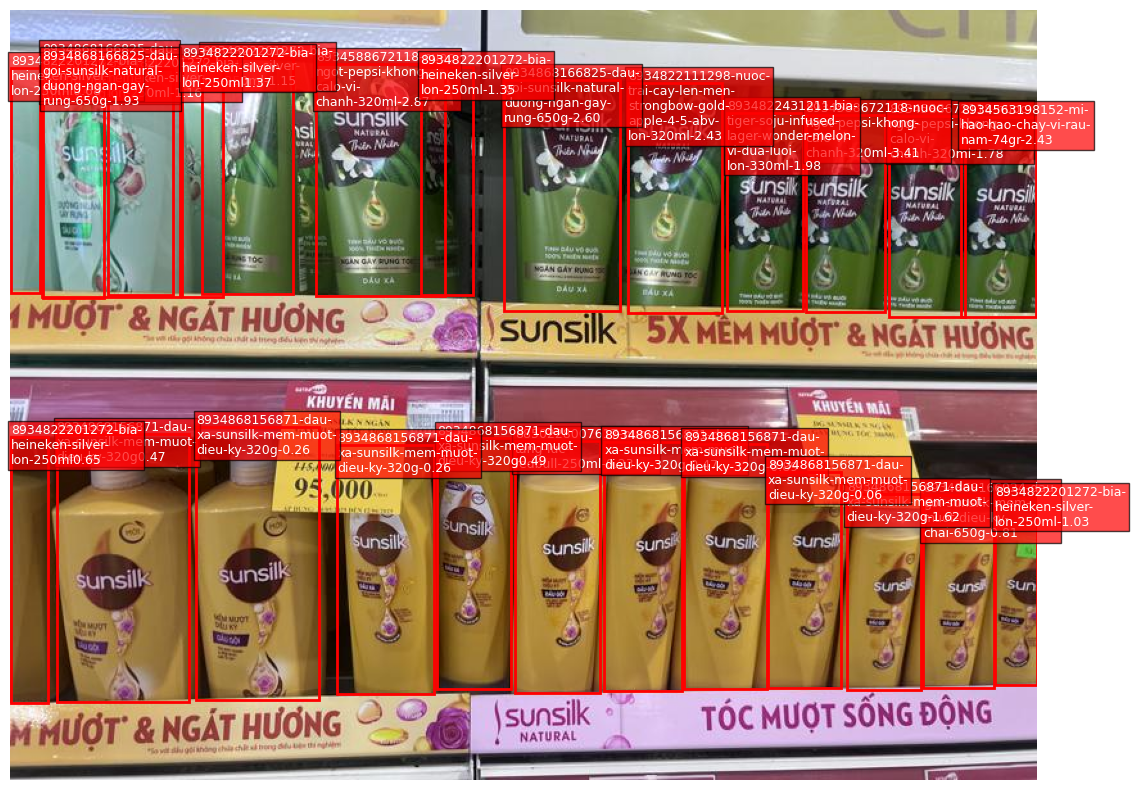

In [31]:
img = Image.open("/Volumes/Cucumber/Projects/datasets/raw/hcmus-iid/val/images/ee826b94357ec326cfed20ac3efa34b7.jpeg").convert("RGB")
img = ImageOps.exif_transpose(img)
result = yolo_model(img)[0]

boxes = []
cropped_imgs = []
for box in result.boxes:
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    boxes.append([x1, y1, x2, y2])
    cropped = img.crop((x1, y1, x2, y2))
    cropped_imgs.append(cropped)

predicted_labels = []
for item in cropped_imgs:
    idx, score = predict_image_class(classifer, item, transform_val)
    label = idx2label[idx] + f"{score:.2f}"
    predicted_labels.append(label)
viz_utils.draw_boxes(img, boxes, predicted_labels)